# Kaggle Study 4일차(타이타닉)

코드출처 : https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

1. Introduction  
2. Load and check data  
    2.1 load data  
    2.2 Outlier detection
    2.3 joining train and test set
    2.4 check for null and missing values
3. Feature analysis
    3.1 Numerical values
    3.2 Categorical values
4. Filling missing Values
    4.1 Age
5. Feature engineering
    5.1 Name/Title
    5.2 Family Size
    5.3 Cabin
    5.4 Ticket
6. Modeling
    6.1 Simple modeling
        6.1.1 Cross validate models
        6.1.2 Hyperparamater tunning for best models
        6.1.3 Plot learning curves
        6.1.4 Feature importance of the tree based classifiers
    6.2 Ensemble modeling
        6.2.1 Combining models
    6.3 Prediction
        6.3.1 Predict and Submit results

## 1회차

## 1. Introduction
- 이 자료는 feature engineering 과 ensemble modeling에 초점을 맞춤
- Feature analysis, Feature engineering, Modeling 이렇게 세 부분에 초점

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

## 2. Load and check data
### 2.1 Load data

In [2]:
train = pd.read_csv('C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/titanic/train.csv')
test = pd.read_csv('C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/titanic/test.csv')
IDtest= test['PassengerId']

### 2.2 Outlier detection
- 터키 검증(Tukey)활용
- 모든 집단의 사례 수가 동수 n이고 평균치 간 일대일 짝 비교를 하고자 할 때 사용하는 사후 검정법.

In [3]:
def detect_outliers(df,n,features):
    
    outlier_indices = []
    
    for col in features:
    
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col],75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

- Tukey 방법(Tukey JW., 1977)을 사용하여 분포 값의 1사분위값과 3사분위값 사이에 구성된 사분위간 범위를 정의하는 아웃라이어(이상값)를 검출했다. 특이치는 형상 값이 (IQR + - 특이치 단계) 외부에 있는 행이다.

- 숫자 값 특징(Age, SibSp, Sarch 및 Fare)에서 특이치를 탐지하기로 결정했다. 그런 다음 특이치를 두 개 이상의 출력된 숫자 값을 갖는 행으로 간주한다.

In [4]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


- 10개의 이상값을 발견함. 28, 89, 342번째 승객은 Fare에서 이상치를 보인다.

- 다른 7명의 승객들은 SibSP에서 이상값이 보인다.

In [5]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

### 2.3 joining train and test set

In [6]:
train_len = len(train)
dataset = pd.concat(objs=[train,test],axis=0).reset_index(drop=True)

- 범주형 데이터 변환중에 동일한 특성을 찾기 위해 두 데이터를 조인 하기로 함

### 2.4 check for null and missing values

In [8]:
dataset = dataset.fillna(np.nan)

dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

- Age,Cabin에서 결측값은 꽤 많은 양을 차지하고 있다.

- Survived는 조인 테스트 데이터 세트에 해당합니다(test에는 결과값이 없기 때문 = NaN값으로 존재)

In [9]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [10]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [12]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## 3. Feature analysis
### 3.1 Numerical values

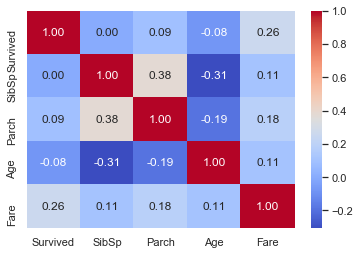

In [14]:
g= sns.heatmap(train[['Survived','SibSp','Parch','Age','Fare']].corr(),annot=True,fmt=".2f",cmap="coolwarm")

- Fare와 Survived에서 유의한 상관관계를 갖는 것으로 보임.
- 나머지 요인이 상관관계를 가지지 않는다는 의미가 아님. => 여러 방법으로 확인할 필요가 있음

#### SibSP

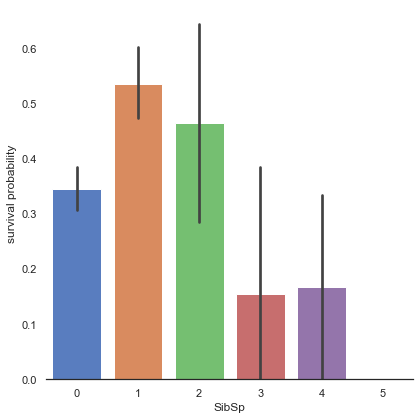

In [23]:
g = sns.catplot(x="SibSp",y="Survived",data=train,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

- 형제 배우자(SibSP)가 많은 승객은 생존기회가 적은 듯 하다.
- SibSP가 0,1,2일때 생존 기회가 많았다.

#### Parch

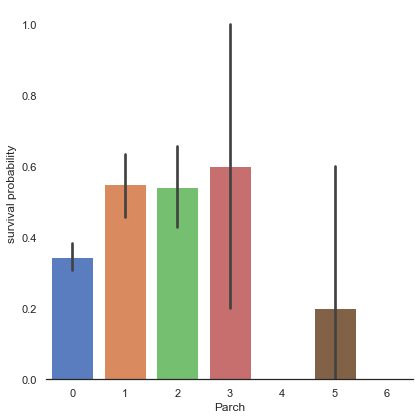

In [24]:
g = sns.catplot(x="Parch",y="Survived",data=train,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

- 가족수가 적을 수록 생존 확률이 높았다.

- 3명의 부모/자녀를 둔 승객의 경우 표준편차가 꽤나 크게 나왔다

#### Age

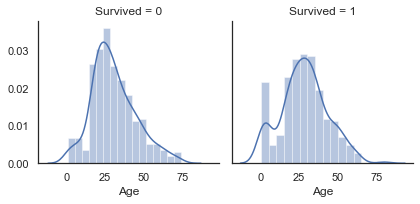

In [25]:
g=sns.FacetGrid(train,col='Survived')
g=g.map(sns.distplot,"Age")

- Age는 Tailed 또는 Gaussian 분포의 모습을 띠고 있다.
- 생존한 사람들을 보면 어린 사람들이 분포 바깥으로 벗어난 것을 볼수 있다. 또한 60세 이상의 사람들이 덜 살아남은것도 확인이 된다.
- 즉 Age도 어느정도 연관성이 있다는 것을 알 수 있다.(어릴수록 생존확률 증가)

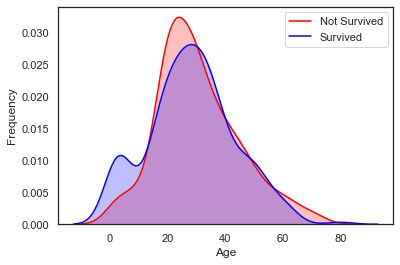

In [27]:
g = sns.kdeplot(train['Age'][(train['Survived']==0)&(train['Age'].notnull())],color='Red',shade=True)
g = sns.kdeplot(train['Age'][(train['Survived']==1)&(train['Age'].notnull())],color='Blue',shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived','Survived'])

- 두 그래프를 겹친 결과 어린 아이들에게 그 분포가 일치하는 것을 볼 수 있다.

#### Fare

In [29]:
dataset['Fare'].isnull().sum()

1

In [31]:
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

- 1개의 missing value는 중앙값으로 채움

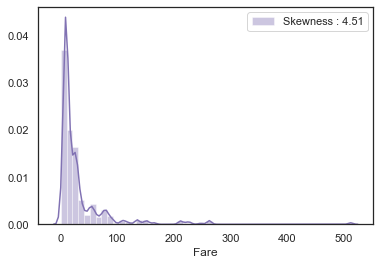

In [32]:
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

- Fare는 조금 많이 치우쳐 있다. -> 로그함수로 변환할 필요가 있음

In [33]:
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i>0 else 0)

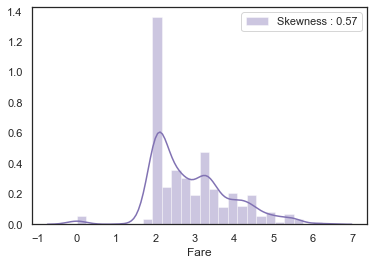

In [34]:
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

- 아까보다 치우침이 적어진 걸 확인할 수 있다.

### 3.2 Categorical values
#### Sex

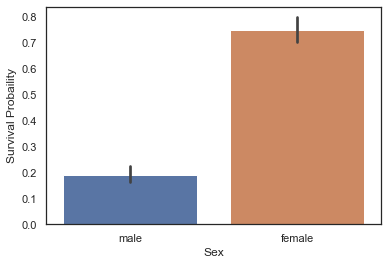

In [35]:
g = sns.barplot(x='Sex',y='Survived',data=train)
g = g.set_ylabel('Survival Probaility')

In [36]:
train[['Sex','Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


- 여성이 남성보다 생존확률이 높음 -> Sex는 생존예측에 중요한 요인이 됨

#### Pclass

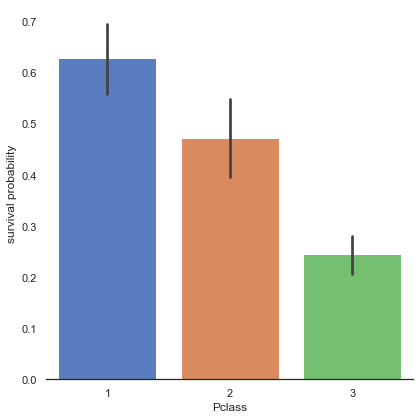

In [38]:
g = sns.catplot(x="Pclass",y="Survived",data=train,kind='bar',height=6,palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

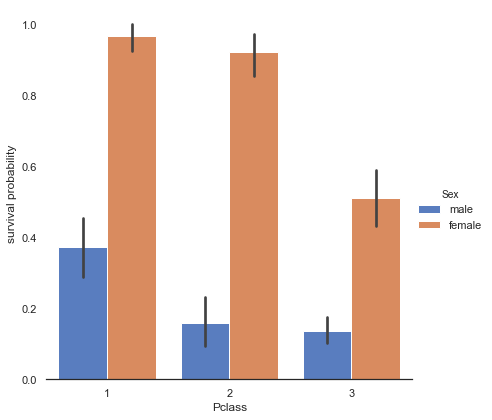

In [39]:
g = sns.catplot(x="Pclass",y="Survived",hue='Sex',data=train,kind='bar',height=6,palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

- 1,2,3 Class 순서로 생존확률이 높음.
- 이러한 경향은 성별에도 적용됨

#### Embarked

In [40]:
dataset["Embarked"].isnull().sum()

2

In [43]:
dataset["Embarked"] = dataset["Embarked"].fillna("S")

- Embarked의 null값은 가장 많이 탑승한 항구 S로 변경함

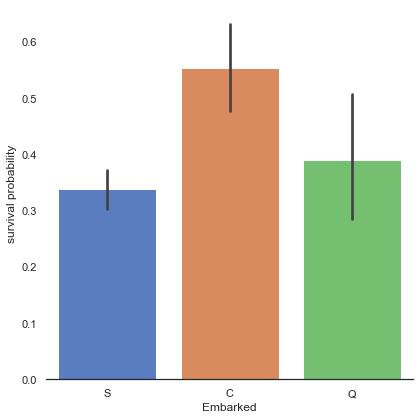

In [45]:
g = sns.catplot(x="Embarked", y="Survived",  data=train, height=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

- Cherbourg에서 온 승객이 가장 많이 살아 남았다.
- 그 다음으론 Queenstown(Q), Southampton (S) 순서로 많았다.

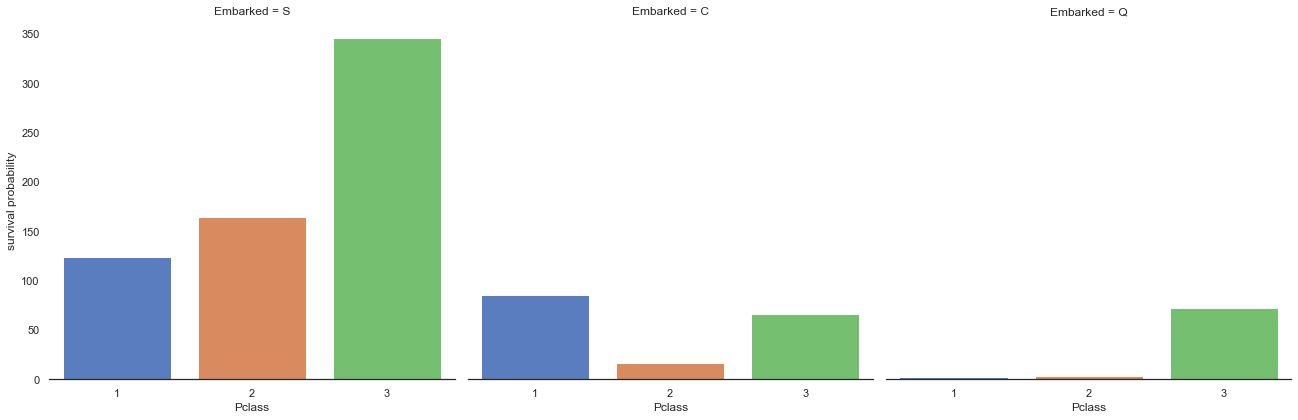

In [48]:
g = sns.factorplot("Pclass", col="Embarked",  data=train, size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

- 실제로 S와 Q에서 오는 승객이 3등석인 반면 C에서 온 승객은 생존율이 가장 높은 1등석인 경우가 대부분이다.

## 4. Filling missing Values
### 4.1 Age

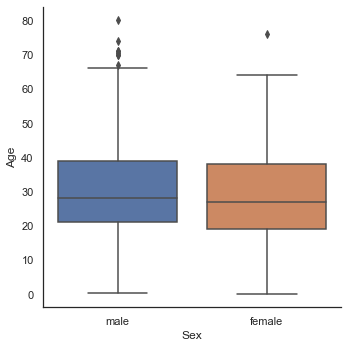

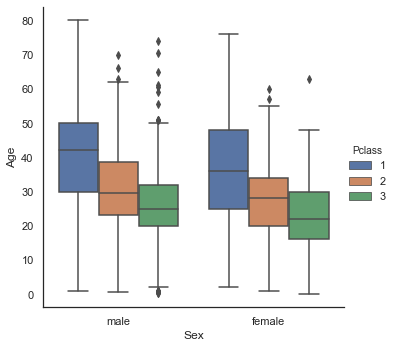

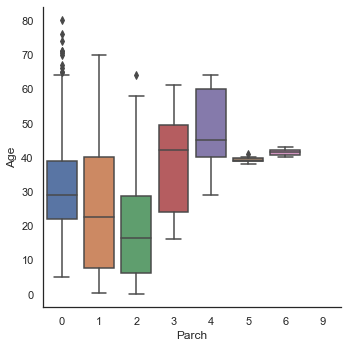

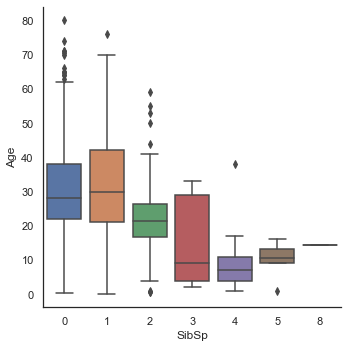

In [50]:
g = sns.catplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.catplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.catplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.catplot(y="Age",x="SibSp", data=dataset,kind="box")

- 연령 분포는 남성과 여성, 둘 다 동일한 것으로 보이므로 성별은 연령을 예측하는 데 유익하지 않다.

- 다만 1,2,3등석 순서대로 나이가 많았다.

- 더욱이, 승객이 부모/자녀를 더 많이 가질수록 나이가 더 많고, 더 어린 승객일수록 형제/배우자가 더 많다.

In [51]:
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

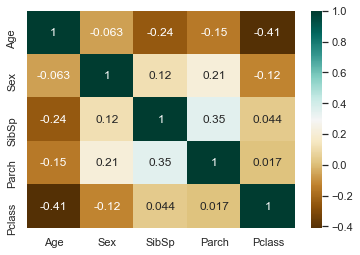

In [52]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

- 나이는 성별과 상관관계가 없지만, Pclass, Parch, SibSp와 부정적으로 상관관계가 있다.

- Parch의 함수의 Age 그림에서는 부모/자녀의 수에 따라 Age가 증가하고 있다. 그러나 일반적인 상관관계는 부정적이다.

- 그래서 SibSP, Parch, Pclass를 사용해서 사라진 나이를 예측해 넣기로 함.

- Pclass, Parch 및 SibSp에 따라 비슷한 행의 중간값으로 Age를 채우기로 했다다.

In [53]:
#이대로 개발해도 나쁘진 않지만, 데이터 프레임을 중첩해서 쓰므로 좋은 형태는 아닌듯

index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

C:\user\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


C:\user\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\user\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


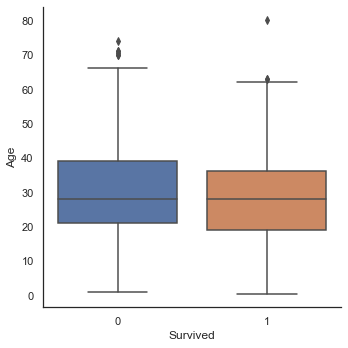

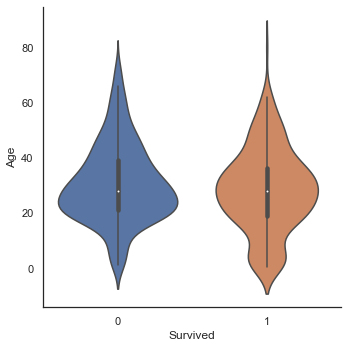

In [54]:
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="violin")

- 생존한 사람과 생존하지 않은 사람 둘 다 중간값의 차이는 크게 없다.

- 하지만 생존한 승객들의 바이올린 그래프에서, 어린 승객들이 더 높은 생존율을 가지고 있다는 것을 확인할 수 있다.

## 5. Feature engineering
### 5.1 Name/Title

In [55]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [57]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

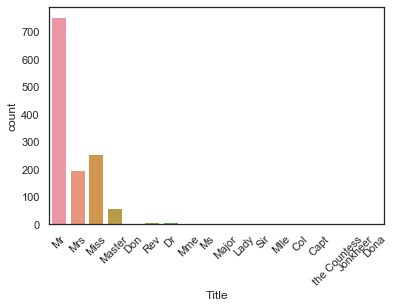

In [58]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

- 데이터셋에 17개의 title이 있는 것을 확인함. 이걸 4개로 줄여보도록 하겠음

In [59]:
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

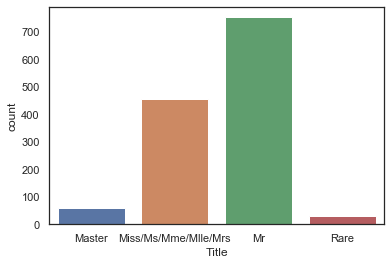

In [60]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

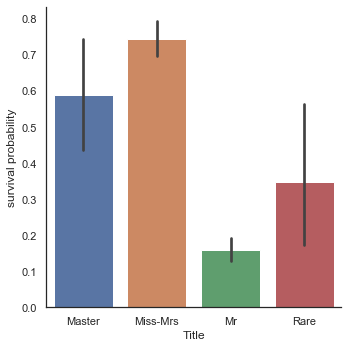

In [61]:
g = sns.catplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels("survival probability")

- 아이와 여성 먼저 구한 것을 확인 할 수 있다.

In [62]:
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

### 5.2 Family size

In [63]:
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

C:\user\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


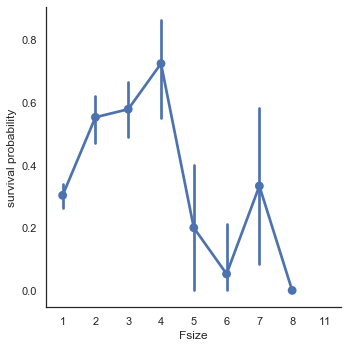

In [66]:
g = sns.factorplot(x="Fsize",y="Survived",data=dataset)
g = g.set_ylabels("survival probability")

- 대가족일수록 생존확률이 낮은걸 보아 가족 규모가 중요한 역할을 하는 것 같다.

- 그래서 가족 크기를 4가지 카테고리를 만들기로 했다.

In [67]:
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

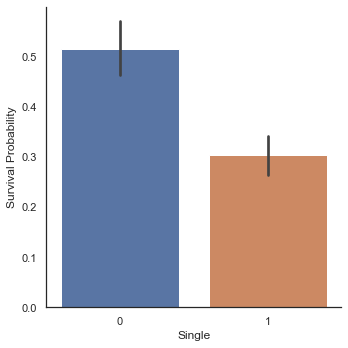

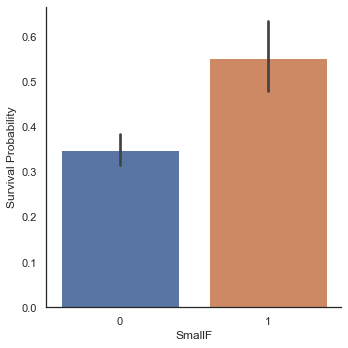

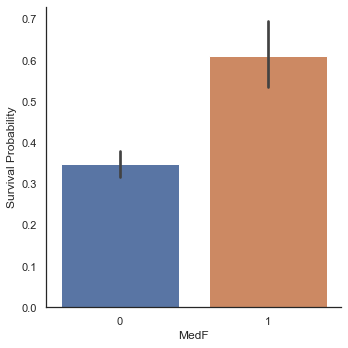

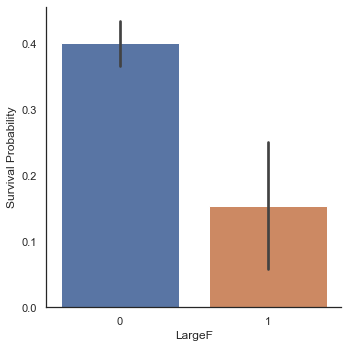

In [68]:
g = sns.catplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

g = sns.catplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

g = sns.catplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

g = sns.catplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

- small,medium이 single,large보다 생존률이 높음

In [69]:
dataset = pd.get_dummies(dataset, columns =['Title'])
dataset = pd.get_dummies(dataset, columns =['Embarked'],prefix="Em")

In [70]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


### 5.3 Cabin

In [71]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [72]:
dataset["Cabin"].describe()

count                 292
unique                186
top       B57 B59 B63 B66
freq                    5
Name: Cabin, dtype: object

In [73]:
dataset["Cabin"].isnull().sum()

1007

- Cabin에는 292개의 값, 1007개의 결측값이 존재

In [74]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [75]:
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

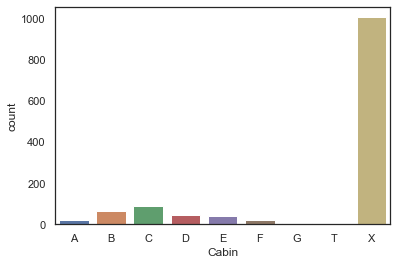

In [77]:
g = sns.countplot(dataset["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

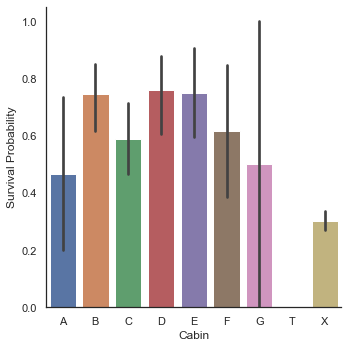

In [79]:
g = sns.catplot(y='Survived',x='Cabin',data=dataset,kind='bar',order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels('Survival Probability')

- 일반적으로 객실을 가진 승객들이 객실이 없는 승객들(X)보다 생존할 수 있는 더 많은 기회를 가지고 있다는 것을 알 수 있다.

In [80]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

### 5.4 Ticket

In [83]:
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

- 같은 단어로 시작하는 티켓은 같은 방에 배정될 확률이 있다.

In [82]:
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [84]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [85]:
dataset["Pclass"]= dataset["Pclass"].astype('category')
dataset= pd.get_dummies(dataset,columns=['Pclass'],prefix="Pc")

In [86]:
dataset.drop(labels =['PassengerId'],axis=1,inplace=True)

In [87]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


## 6. MODELING

In [89]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

C:\user\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [90]:
train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)

C:\user\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### 6.1 Simple modeling
#### 6.1.1 Cross validate models

[사용한 모델들]
- SVC
- Decision Tree
- AdaBoost
- Random Forest
- Extra Trees
- Gradient Boosting
- Multiple layer perceprton (neural network)
- KNN
- Logistic regression
- Linear Discriminant Analysis

In [91]:
kfold = StratifiedKFold(n_splits=10)

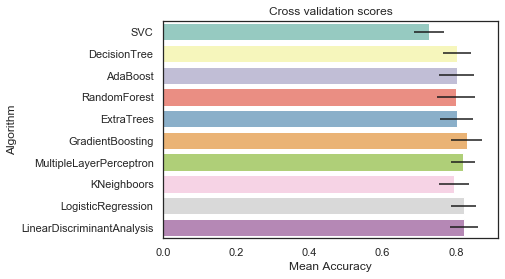

In [94]:
random_state = 2
classifiers = []

classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results=[]
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier,X_train,y=Y_train,scoring='accuracy',cv=kfold,n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

- SVC, AdaBoost, RandomForest , ExtraTrees, the GradientBoosting classifiers 를 앙상블 하기로 결정

#### 6.1.2 Hyperparameter tunning for best models
- AdaBoost, ExtraTree, RandomForest, GradientBoosting 및 SVC 분류기에 대한 그리드 검색 최적화(grid search optimization)를 수행했다.

- 최초 코드 작성자는 4개의 cpu를 가진 컴퓨터여서 "n_jobs" 매개 변수를 4로 설정했다. 이러면 계산 시간이 분명히 단축된다고 한다. (이것 역시 캐바캐)

In [95]:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 312 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    2.8s finished


In [96]:
gsadaDTC.best_score_

0.82073544433095

In [99]:
#ExtraTrees
ExtC = ExtraTreesClassifier()

ex_param_grid = {"max_depth":[None],
                "max_features":[1,3,10],
                "min_samples_split":[2,3,10],
                "min_samples_leaf":[1,3,10],
                "bootstrap":[False],
                "n_estimators":[100,300],
                "criterion":["gini"]}

gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring='accuracy',n_jobs=4,verbose=1)

gsExtC.fit(X_train,Y_train) 

ExtC_best = gsExtC.best_estimator_

gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   22.0s
[Parallel(n_jobs=4)]: Done 533 out of 540 | elapsed:   32.8s remaining:    0.3s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   33.1s finished


0.8297497446373852

In [101]:
#RFC Parameters tunning
RFC = RandomForestClassifier()

rf_param_grid = {"max_depth":[None],
                "max_features":[1,3,10],
                "min_samples_split":[2,3,10],
                "min_samples_leaf":[1,3,10],
                "bootstrap":[False],
                "n_estimators":[100,300],
                "criterion":["gini"]}

gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring='accuracy',n_jobs=4,verbose=1)

gsRFC.fit(X_train,Y_train) 

RFC_best = gsRFC.best_estimator_

gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   23.9s
[Parallel(n_jobs=4)]: Done 533 out of 540 | elapsed:   36.0s remaining:    0.4s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   36.5s finished


0.8308861082737486

In [102]:
#Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {"loss":['deviance'],
                 'n_estimators' : [100,200,300],
                 "learning_rate":[0.1,0.05,0.01],
                 "max_depth":[4,8],
                "min_samples_leaf":[1,3,10],
                 "max_features":[0.3,0.1]}

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring='accuracy',n_jobs=4,verbose=1)

gsGBC.fit(X_train,Y_train) 

GBC_best = gsGBC.best_estimator_

gsGBC.best_score_

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 296 tasks      | elapsed:   24.3s
[Parallel(n_jobs=4)]: Done 546 tasks      | elapsed:   38.6s
[Parallel(n_jobs=4)]: Done 896 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 1080 out of 1080 | elapsed:  1.5min finished


0.8388406537282942

In [103]:
#SVC Classifier

SVMC = SVC(probability=True)
svc_param_grid = {"kernel":['rbf'],
                 "gamma":[0.001,0.001,0.1,1],
                 'C':[1,10,50,100,200,300,1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring='accuracy',n_jobs=4,verbose=1)

gsSVMC.fit(X_train,Y_train) 

SVMC_best = gsSVMC.best_estimator_

gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.9s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   20.0s finished


0.8286006128702759

#### 6.1.3 Plot learning curves
- 학습 곡선(Plot learning curves)은 훈련 세트에 대한 과적합 효과와 훈련 크기가 정확도에 미치는 영향을 확인할 수 있는 좋은 방법이다.

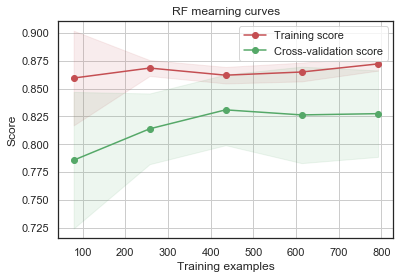

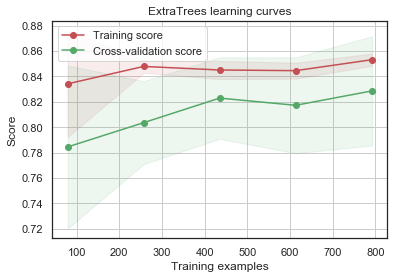

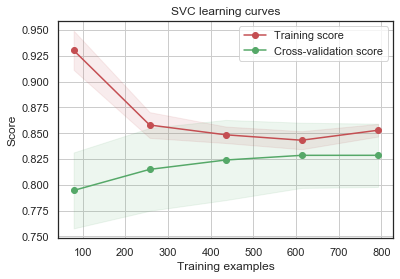

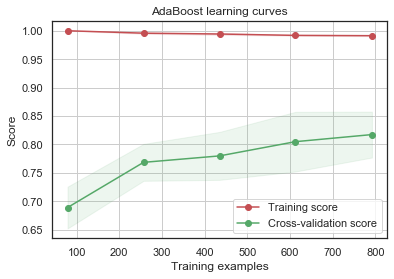

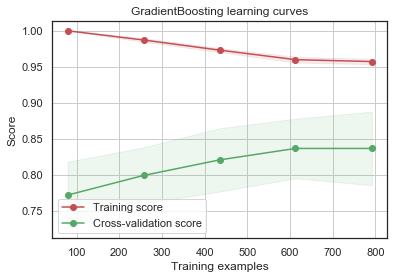

In [104]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

- GradientBoosting 및 Adaboost 분류기는 데이터셋에 과적합하는 경향이 있다.
- 교차 검증 곡선에 따라 GradientBoosting과 Adaboost는 더 많은 훈련 예제가 들어가면 성능이 더 좋았다.
- SVC와 ExtraTree 분류기는 훈련 곡선과 교차 검증 곡선이 밀접하기 때문에 예측을 더 잘 일반화시키는 것으로 보인다.

#### 6.1.4 Feature importance of tree based classifiers

- 생존가능성을 예측하기에 가장 중요한 요인을 찾기 위해(Feature Importance) 4개의 트리 기반 분류기에 대한 기능 중요성을 표시해보았다.

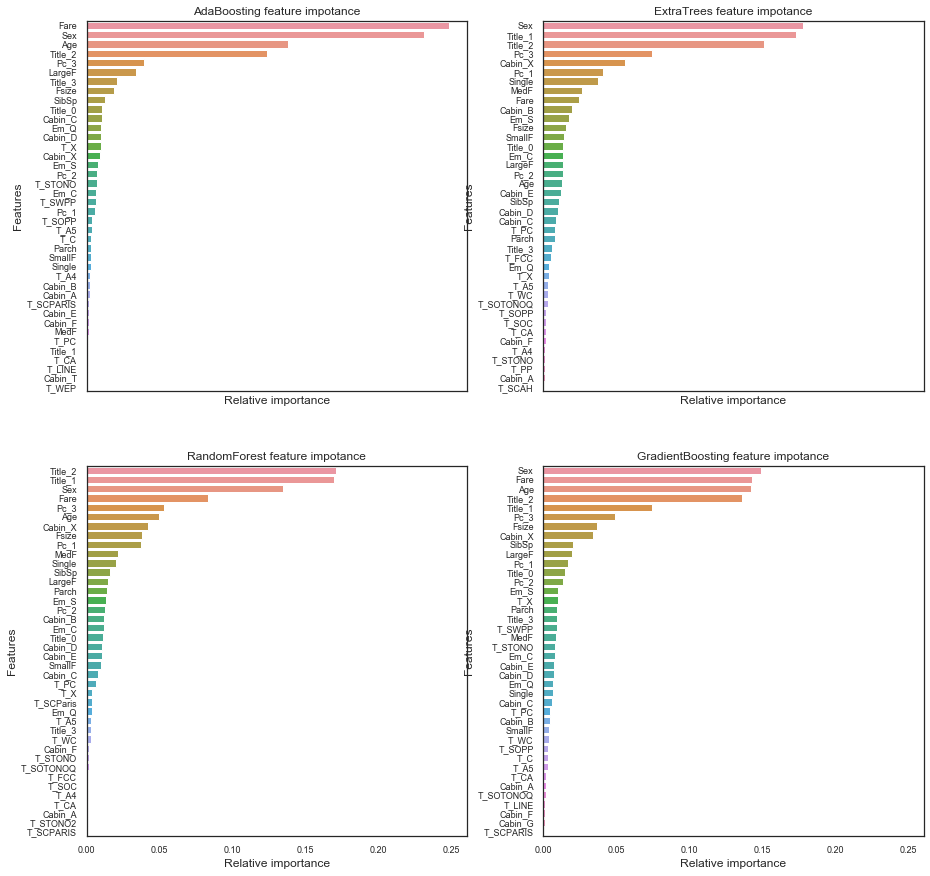

In [108]:
nrows = ncols = 2
fig,axes = plt.subplots(nrows = nrows, ncols = ncols, sharex='all',figsize=(15,15))

names_classifiers =[("AdaBoosting",ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x=classifier.feature_importances_[indices][:40],orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name+" feature impotance")
        nclassifier +=1

- 4개의 트리 기반 분류기(Adboost, ExtraTree, RandomForest 및 GradientBoosting)에 대한 기능 중요도를 표시합니다.

- 우리는 네 개의 분류기가 상대적 중요도에 따라 상위 특징을 가지고 있다는 것에 확인할 수 있다. 모두 다 똑같은 순서를 가지지 않지만 'Fare', 'Title_2', 'Age', 'Sex'와 같은 몇 가지 공통의 중요한 특징을 공유하고 있는 것을 볼 수 있다.

- Ms/Mlle/Mme/Miss/Ms 범주가 Sex와 높은 상관 관계를 가지고 있음을 나타내는 Title_2이다.

<요약>

- Pc_1, Pc_2, Pc_3, 요금은 승객의 일반적인 사회적 지위를 의미한다.

- 성별 및 제목_2(Mrs/Mlle/Mme/Ms)와 제목_3(Mr)은 성별을 나타냅니다.

- 나이 및 제목_1(주)은 승객의 나이를 나타냅니다.

- Fsize, LargeF, MedF, Single은 승객 패밀리의 크기를 나타냅니다.

이 4가지 분류기의 특징적 중요성에 따르면 생존 예측은 보트 안 위치보다 승객들의 연령, 성별, 가족 규모, 사회적 지위 등과 더 관련이 있는 것으로 보인다.

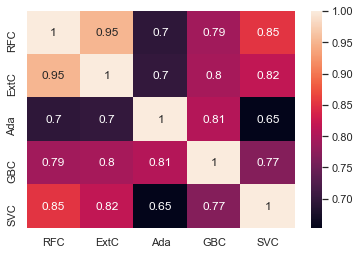

In [107]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

- AdaBoost를 다른 분류기와 비교할 때를 제외하고는 5개의 분류자에 대한 예측은 매우 유사한 것으로 보인다.

- 5개의 분류기는 거의 같은 예측을 제공하지만 약간의 차이가 있다. 5개의 분류자 예측 간의 이러한 차이는 조합 투표를 고려하기에 충분하다.

### 6.2 Ensemble modeling
#### 6.2.1 Combining models

- 제작자는 5개의 분류기에서 나오는 예측들을 조합하기 위해 Voting를 선택했다.그리고 voting 옵션은 soft를 사용했다.

In [109]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best), ('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

### 6.3 Prediction
#### 6.3.1 Predict and Submit results

In [110]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)

## 2회차

## 1. Introduction
- 이 자료는 feature engineering 과 ensemble modeling에 초점을 맞춤
- Feature analysis, Feature engineering, Modeling 이렇게 세 부분에 초점

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,ExtraTreesClassifier,VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve


sns.set(style='white',context='notebook',palette='deep')

## 2. Load and check data
### 2.1 Load data

In [115]:
train = pd.read_csv('C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/titanic/train.csv')
test = pd.read_csv('C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/titanic/test.csv')
IDtest=test['PassengerId']

### 2.2 Outlier detection
- 터키 검증(Tukey)활용
- 모든 집단의 사례 수가 동수 n이고 평균치 간 일대일 짝 비교를 하고자 할 때 사용하는 사후 검정법.

In [117]:
def detect_outlier(df,n,features):
    
    outlier_indices=[]
    
    for col in features:
        Q1= np.percentile(df[col],25)
        Q3= np.percentile(df[col],75)
        IQR = Q3-Q1
        
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col]<Q1-outlier_step)|(df[col]>Q3+outlier_step)].index
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v>n)

    return multiple_outliers   

Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

- Tukey 방법(Tukey JW., 1977)을 사용하여 분포 값의 1사분위값과 3사분위값 사이에 구성된 사분위간 범위를 정의하는 아웃라이어(이상값)를 검출했다. 특이치는 형상 값이 (IQR + - 특이치 단계) 외부에 있는 행이다.

- 숫자 값 특징(Age, SibSp, Sarch 및 Fare)에서 특이치를 탐지하기로 결정했다. 그런 다음 특이치를 두 개 이상의 출력된 숫자 값을 갖는 행으로 간주한다.

In [118]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


- 10개의 이상값을 발견함. 28, 89, 342번째 승객은 Fare에서 이상치를 보인다.

- 다른 7명의 승객들은 SibSP에서 이상값이 보인다.

In [119]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

### 2.3 joining train and test set

In [120]:
train_len = len(train)
dataset = pd.concat(objs=[train,test],axis=0).reset_index(drop=True)

- 범주형 데이터 변환중에 동일한 특성을 찾기 위해 두 데이터를 조인 하기로 함

### 2.4 check for null and missing values

In [121]:
dataset = dataset.fillna(np.nan)

dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

- Age,Cabin에서 결측값은 꽤 많은 양을 차지하고 있다.

- Survived는 조인 테스트 데이터 세트에 해당합니다(test에는 결과값이 없기 때문 = NaN값으로 존재)

In [122]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [123]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [124]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [126]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## 3. Feature analysis
### 3.1 Numerical values

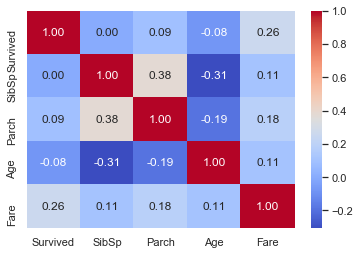

In [128]:
g=sns.heatmap(train[['Survived','SibSp','Parch','Age','Fare']].corr(),annot=True,fmt=".2f",cmap="coolwarm")

- Fare와 Survived에서 유의한 상관관계를 갖는 것으로 보임.
- 나머지 요인이 상관관계를 가지지 않는다는 의미가 아님. => 여러 방법으로 확인할 필요가 있음

#### SibSP

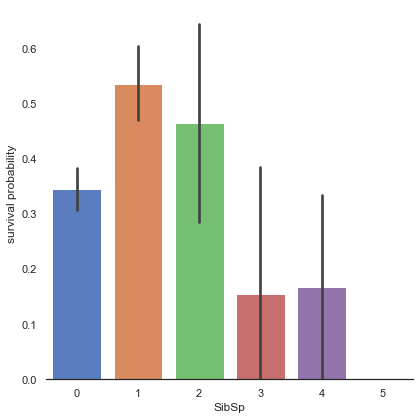

In [129]:
g=sns.catplot(x="SibSp",y='Survived',data=train,kind='bar',height=6,palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

- 형제 배우자(SibSP)가 많은 승객은 생존기회가 적은 듯 하다.
- SibSP가 0,1,2일때 생존 기회가 많았다.

#### Parch

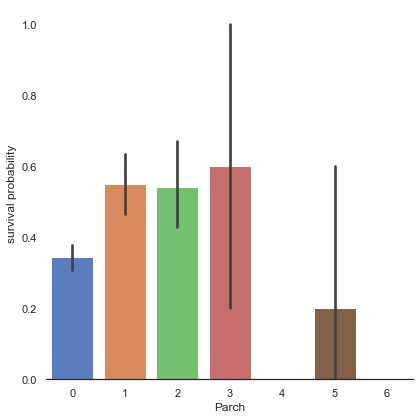

In [130]:
g = sns.catplot(x="Parch",y="Survived",data=train,kind="bar", height = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

- 가족수가 적을 수록 생존 확률이 높았다.

- 3명의 부모/자녀를 둔 승객의 경우 표준편차가 꽤나 크게 나왔다

#### Age

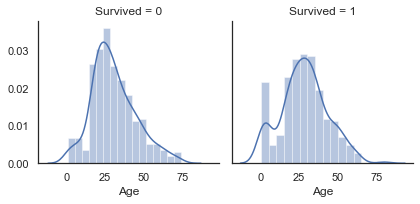

In [131]:
g=sns.FacetGrid(train,col='Survived')
g=g.map(sns.distplot,"Age")

- Age는 Tailed 또는 Gaussian 분포의 모습을 띠고 있다.
- 생존한 사람들을 보면 어린 사람들이 분포 바깥으로 벗어난 것을 볼수 있다. 또한 60세 이상의 사람들이 덜 살아남은것도 확인이 된다.
- 즉 Age도 어느정도 연관성이 있다는 것을 알 수 있다.(어릴수록 생존확률 증가)

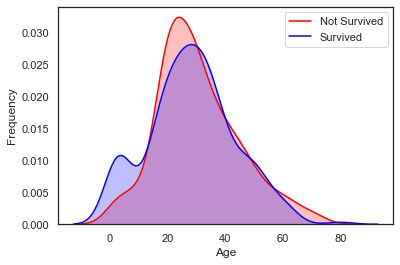

In [132]:
g = sns.kdeplot(train['Age'][(train['Survived']==0)&(train['Age'].notnull())],color='Red',shade=True)
g = sns.kdeplot(train['Age'][(train['Survived']==1)&(train['Age'].notnull())],color='Blue',shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived','Survived'])

- 두 그래프를 겹친 결과 어린 아이들에게 그 분포가 일치하는 것을 볼 수 있다.

#### Fare

In [133]:
dataset['Fare'].isnull().sum()

1

In [134]:
dataset['Fare'] = dataset['Fare'].fillna((dataset['Fare'].median()))

- 1개의 missing value는 중앙값으로 채움

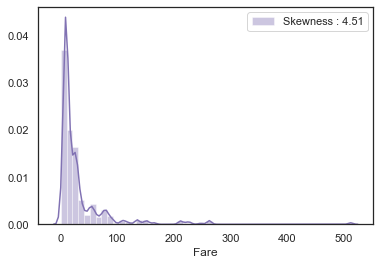

In [135]:
g = sns.distplot(dataset['Fare'],color='m',label='Skewness : %.2f'%(dataset['Fare'].skew()))
g=g.legend(loc='best')

- Fare는 조금 많이 치우쳐 있다. -> 로그함수로 변환할 필요가 있음

In [136]:
dataset['Fare'] = dataset['Fare'].map(lambda i:np.log(i) if i>0 else 0)

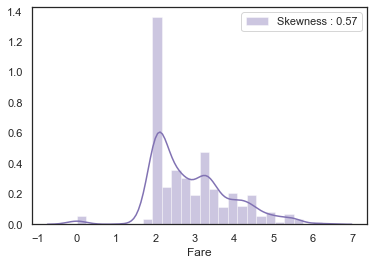

In [137]:
g = sns.distplot(dataset['Fare'],color='m',label='Skewness : %.2f'%(dataset['Fare'].skew()))
g=g.legend(loc='best')

- 아까보다 치우침이 적어진 걸 확인할 수 있다.

### 3.2 Categorical values
#### Sex

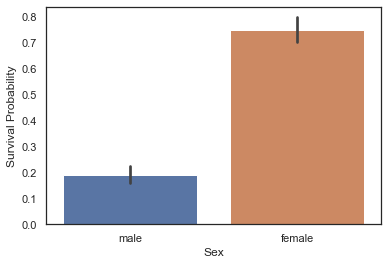

In [139]:
g = sns.barplot(x='Sex',y='Survived',data=train)
g = g.set_ylabel('Survival Probability')

In [140]:
train[['Sex','Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


- 여성이 남성보다 생존확률이 높음 -> Sex는 생존예측에 중요한 요인이 됨

#### Pclass

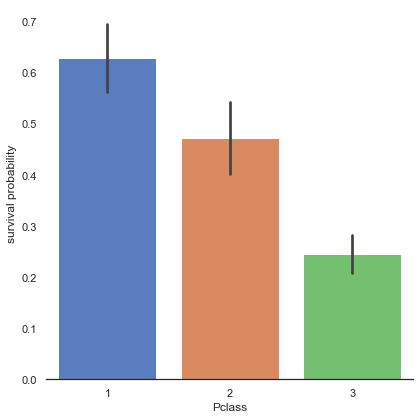

In [141]:
g= sns.catplot(x='Pclass',y='Survived',data=train,kind='bar',height=6,palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

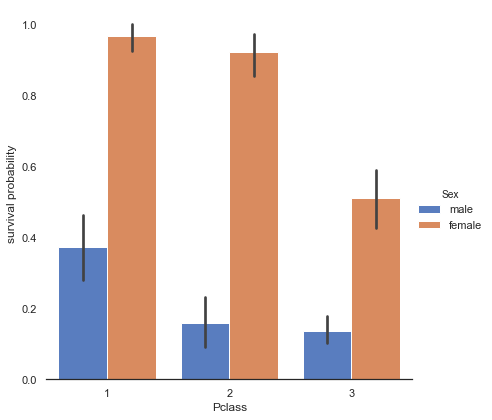

In [142]:
g= sns.catplot(x='Pclass',y='Survived',hue='Sex',data=train,kind='bar',height=6,palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

- 1,2,3 Class 순서로 생존확률이 높음.
- 이러한 경향은 성별에도 적용됨

#### Embarked

In [144]:
dataset["Embarked"].isnull().sum()

2

In [145]:
dataset["Embarked"] = dataset["Embarked"].fillna('S')

- Embarked의 null값은 가장 많이 탑승한 항구 S로 변경함

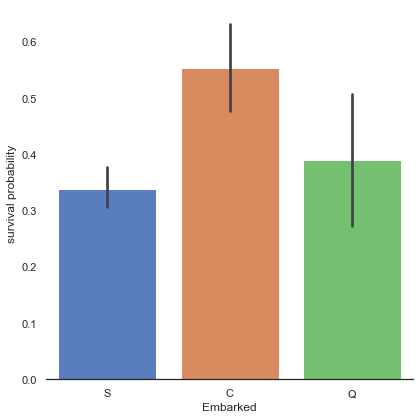

In [147]:
g= sns.catplot(x='Embarked',y='Survived',data=train,kind='bar',height=6,palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

- Cherbourg에서 온 승객이 가장 많이 살아 남았다.
- 그 다음으론 Queenstown(Q), Southampton (S) 순서로 많았다.

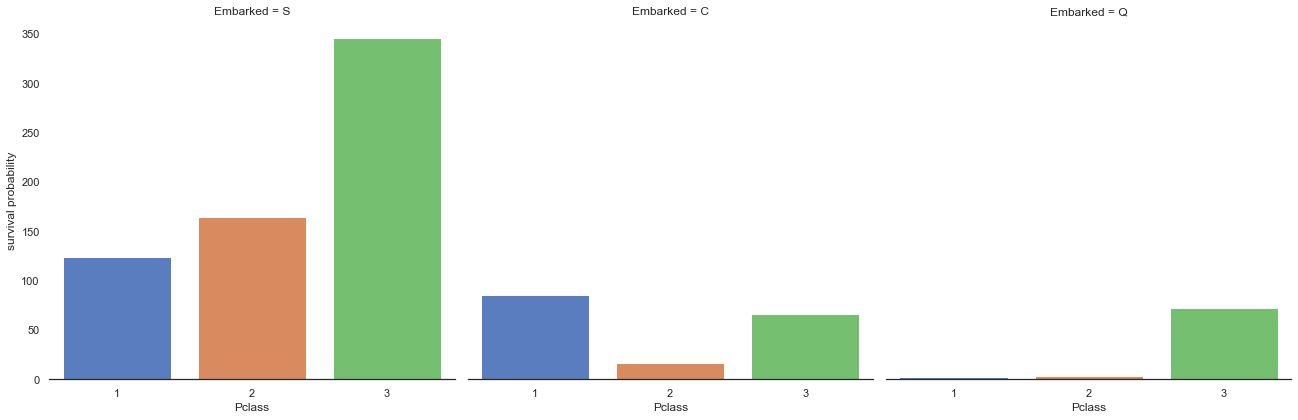

In [151]:
g= sns.catplot('Pclass',col='Embarked',data=train,kind='count',height=6,palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

- 실제로 S와 Q에서 오는 승객이 3등석인 반면 C에서 온 승객은 생존율이 가장 높은 1등석인 경우가 대부분이다.

## 4. Filling missing Values
### 4.1 Age

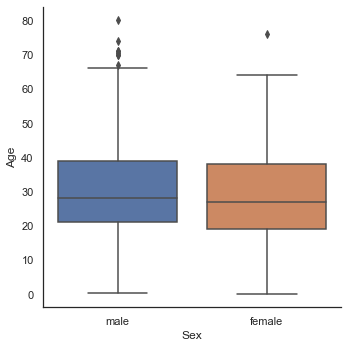

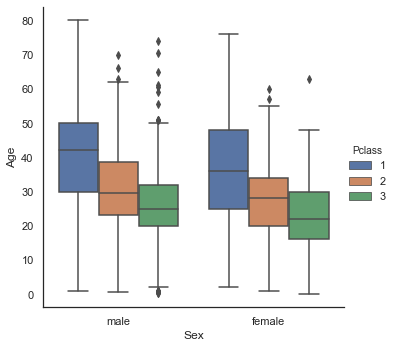

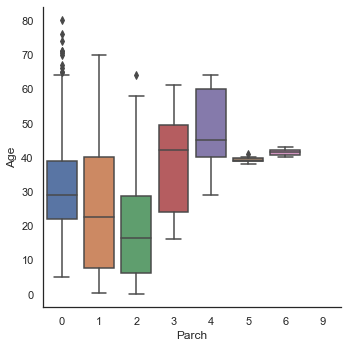

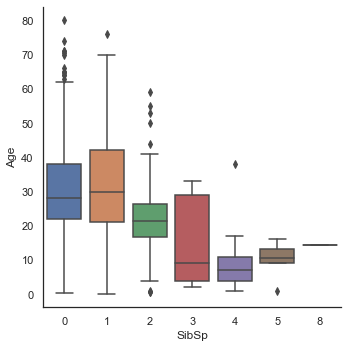

In [153]:
g = sns.catplot(y="Age",x="Sex",data=dataset,kind='box')
g = sns.catplot(y="Age",x="Sex",hue='Pclass',data=dataset,kind='box')
g = sns.catplot(y="Age",x="Parch",data=dataset,kind='box')
g = sns.catplot(y="Age",x="SibSp",data=dataset,kind='box')

- 연령 분포는 남성과 여성, 둘 다 동일한 것으로 보이므로 성별은 연령을 예측하는 데 유익하지 않다.

- 다만 1,2,3등석 순서대로 나이가 많았다.

- 더욱이, 승객이 부모/자녀를 더 많이 가질수록 나이가 더 많고, 더 어린 승객일수록 형제/배우자가 더 많다.

In [154]:
dataset["Sex"] = dataset["Sex"].map({'male':0,'female':1})

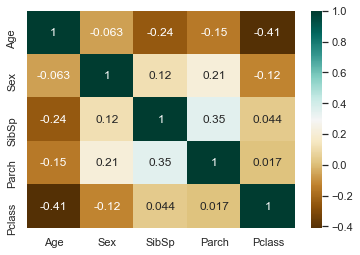

In [155]:
g = sns.heatmap(dataset[['Age','Sex','SibSp','Parch','Pclass']].corr(),cmap="BrBG",annot=True)

- 나이는 성별과 상관관계가 없지만, Pclass, Parch, SibSp와 부정적으로 상관관계가 있다.

- Parch의 함수의 Age 그림에서는 부모/자녀의 수에 따라 Age가 증가하고 있다. 그러나 일반적인 상관관계는 부정적이다.

- 그래서 SibSP, Parch, Pclass를 사용해서 사라진 나이를 예측해 넣기로 함.

- Pclass, Parch 및 SibSp에 따라 비슷한 행의 중간값으로 Age를 채우기로 했다다.

In [156]:
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"])& (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i]=age_pred
    else :
        dataset['Age'].iloc[i]=age_med

C:\user\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


C:\user\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\user\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


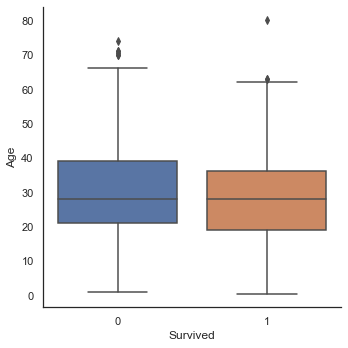

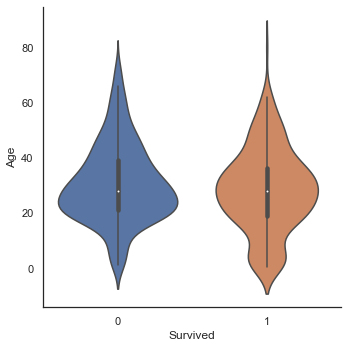

In [157]:
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="violin")

- 생존한 사람과 생존하지 않은 사람 둘 다 중간값의 차이는 크게 없다.

- 하지만 생존한 승객들의 바이올린 그래프에서, 어린 승객들이 더 높은 생존율을 가지고 있다는 것을 확인할 수 있다.

## 5. Feature engineering
### 5.1 Name/Title

In [158]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [160]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

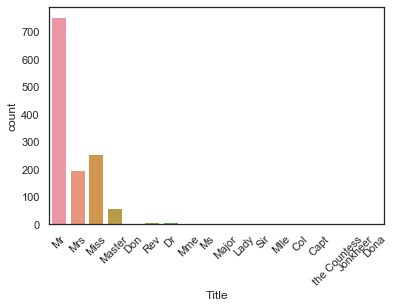

In [161]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(),rotation=45)

- 데이터셋에 17개의 title이 있는 것을 확인함. 이걸 4개로 줄여보도록 하겠음

In [162]:
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

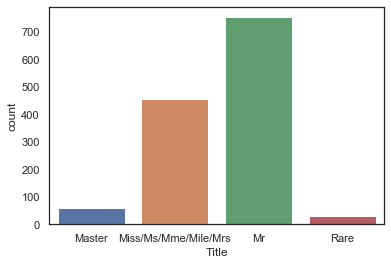

In [163]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mile/Mrs","Mr","Rare"])

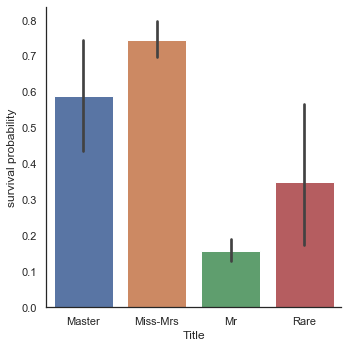

In [164]:
g = sns.catplot(x="Title",y='Survived',data=dataset,kind='bar')
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])
g = g.set_ylabels('survival probability')

- 아이와 여성 먼저 구한 것을 확인 할 수 있다.

In [167]:
dataset.drop(labels = ["Name"],axis=1,inplace=True)

### 5.2 Family size

In [168]:
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

C:\user\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


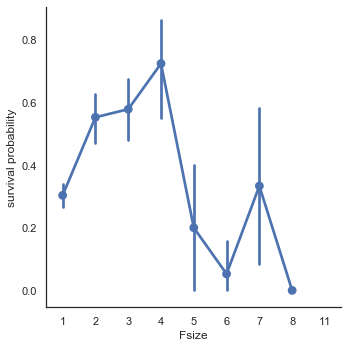

In [169]:
g = sns.factorplot(x="Fsize",y="Survived",data=dataset)
g = g.set_ylabels('survival probability')

- 대가족일수록 생존확률이 낮은걸 보아 가족 규모가 중요한 역할을 하는 것 같다.

- 그래서 가족 크기를 4가지 카테고리를 만들기로 했다.

In [170]:
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3<=s<=4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >=5 else 0)

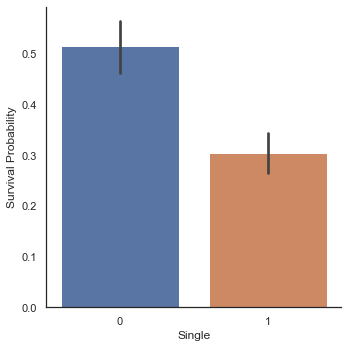

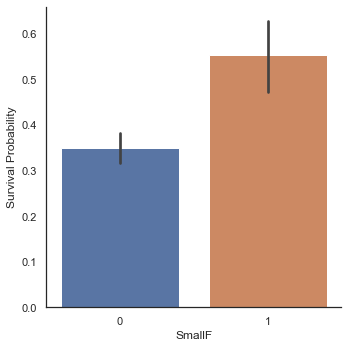

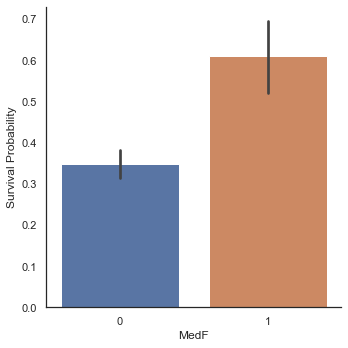

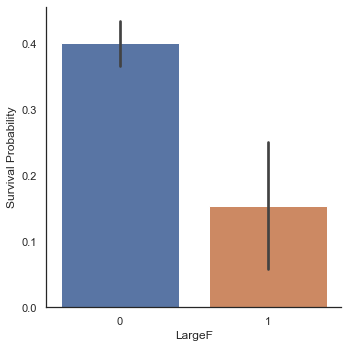

In [172]:
g = sns.catplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels('Survival Probability')

g = sns.catplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels('Survival Probability')

g = sns.catplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels('Survival Probability')

g = sns.catplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels('Survival Probability')

- small,medium이 single,large보다 생존률이 높음

In [173]:
dataset = pd.get_dummies(dataset, columns=['Title'])
dataset = pd.get_dummies(dataset, columns=['Embarked'],prefix='Em')

In [174]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


### 5.3 Cabin

In [175]:
dataset["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [176]:
dataset["Cabin"].describe()

count                 292
unique                186
top       B57 B59 B63 B66
freq                    5
Name: Cabin, dtype: object

In [178]:
dataset["Cabin"].isnull().sum()

1007

- Cabin에는 292개의 값, 1007개의 결측값이 존재

In [179]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [180]:
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

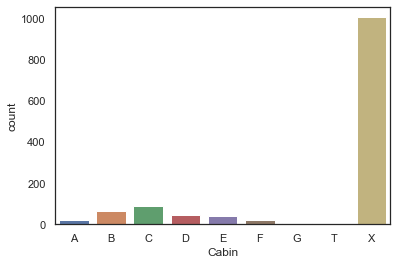

In [181]:
g = sns.countplot(dataset['Cabin'],order=['A','B','C','D','E','F','G','T','X'])

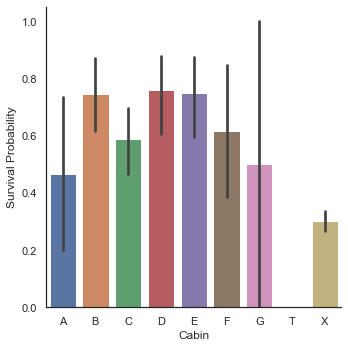

In [182]:
g = sns.catplot(y='Survived',x='Cabin',data=dataset,kind='bar',order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels('Survival Probability')

- 일반적으로 객실을 가진 승객들이 객실이 없는 승객들(X)보다 생존할 수 있는 더 많은 기회를 가지고 있다는 것을 알 수 있다.

In [183]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

### 5.4 Ticket

In [184]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

- 같은 단어로 시작하는 티켓은 같은 방에 배정될 확률이 있다.

In [186]:
Ticket=[]
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0])
    else:
        Ticket.append("X")

dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [187]:
dataset = pd.get_dummies(dataset,columns=["Ticket"],prefix="T")

In [188]:
dataset["Pclass"] = dataset["Pclass"].astype('category')
dataset = pd.get_dummies(dataset,columns=["Pclass"],prefix="Pc")

In [189]:
dataset.drop(labels=['PassengerId'],axis=1,inplace=True)

In [190]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


## 6. MODELING

In [192]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['Survived'],axis=1,inplace=True)

C:\user\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [193]:
train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]
X_train = train.drop(labels = ['Survived'],axis=1)

C:\user\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### 6.1 Simple modeling
#### 6.1.1 Cross validate models

[사용한 모델들]
- SVC
- Decision Tree
- AdaBoost
- Random Forest
- Extra Trees
- Gradient Boosting
- Multiple layer perceprton (neural network)
- KNN
- Logistic regression
- Linear Discriminant Analysis

In [194]:
kfold= StratifiedKFold(n_splits=10)

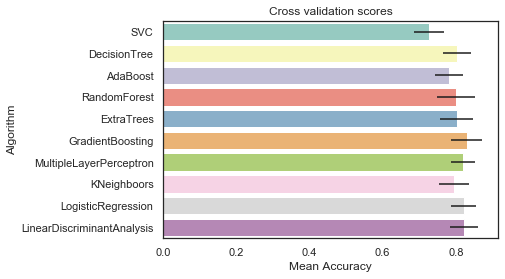

In [198]:
random_state = 2
classifiers = []

classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state)))
classifiers.append(RandomForestClassifier(random_state=random_state))                   
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results=[]
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier,X_train,y=Y_train,scoring='accuracy',cv=kfold,n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,
                       "CrossValerrors":cv_std,
                       "Algorithm":["SVC","DecisionTree","AdaBoost","RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

- SVC, AdaBoost, RandomForest , ExtraTrees, the GradientBoosting classifiers 를 앙상블 하기로 결정

#### 6.1.2 Hyperparameter tunning for best models
- AdaBoost, ExtraTree, RandomForest, GradientBoosting 및 SVC 분류기에 대한 그리드 검색 최적화(grid search optimization)를 수행했다.

- 최초 코드 작성자는 4개의 cpu를 가진 컴퓨터여서 "n_jobs" 매개 변수를 4로 설정했다. 이러면 계산 시간이 분명히 단축된다고 한다. (이것 역시 캐바캐)

In [200]:
#DecisionTree
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    5.2s finished


In [201]:
gsadaDTC.best_score_

0.82073544433095

In [204]:
#ExtraTrees
ExtC = ExtraTreesClassifier()

ex_param_grid = {"max_depth":[None],
                "max_features":[1,3,10],
                "min_samples_split":[2,3,10],
                "min_samples_leaf":[1,3,10],
                "bootstrap":[False],
                "n_estimators":[100,300],
                "criterion":["gini"]}

gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring='accuracy',n_jobs=4,verbose=1)

gsExtC.fit(X_train,Y_train) 

ExtC_best = gsExtC.best_estimator_

gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   51.5s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   57.9s finished


0.8297369765066394

In [205]:
#Random Forest
RFC = RandomForestClassifier()

rf_param_grid = {"max_depth":[None],
                "max_features":[1,3,10],
                "min_samples_split":[2,3,10],
                "min_samples_leaf":[1,3,10],
                "bootstrap":[False],
                "n_estimators":[100,300],
                "criterion":["gini"]}

gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring='accuracy',n_jobs=4,verbose=1)

gsRFC.fit(X_train,Y_train) 

RFC_best = gsRFC.best_estimator_

gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   24.6s
[Parallel(n_jobs=4)]: Done 533 out of 540 | elapsed:   36.5s remaining:    0.4s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   36.9s finished


0.8320224719101124

In [206]:
#Gradient Boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {"loss":['deviance'],
                 'n_estimators' : [100,200,300],
                 "learning_rate":[0.1,0.05,0.01],
                 "max_depth":[4,8],
                "min_samples_leaf":[1,3,10],
                 "max_features":[0.3,0.1]}

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring='accuracy',n_jobs=4,verbose=1)

gsGBC.fit(X_train,Y_train) 

GBC_best = gsGBC.best_estimator_

gsGBC.best_score_

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
C:\user\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   18.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   51.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 1080 out of 1080 | elapsed:  2.5min finished


0.8399514811031665

In [207]:
#SVC classifier

SVMC = SVC(probability=True)
svc_param_grid = {"kernel":['rbf'],
                 "gamma":[0.001,0.01,0.1,1],
                 "C":[1,10,50,100,200,300,1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring='accuracy',n_jobs=4,verbose=1)

gsSVMC.fit(X_train,Y_train) 

SVMC_best = gsSVMC.best_estimator_

gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.9s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   34.7s finished


0.8331332992849847

#### 6.1.3 Plot learning curves
- 학습 곡선(Plot learning curves)은 훈련 세트에 대한 과적합 효과와 훈련 크기가 정확도에 미치는 영향을 확인할 수 있는 좋은 방법이다.

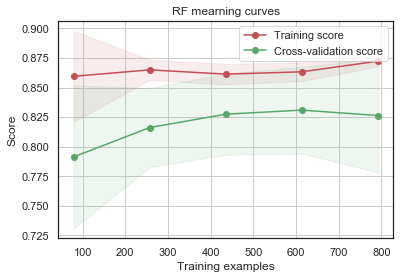

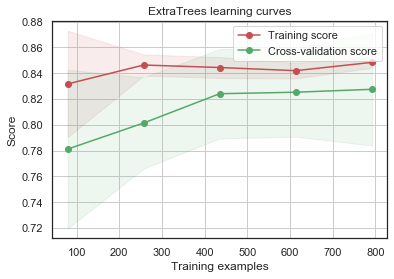

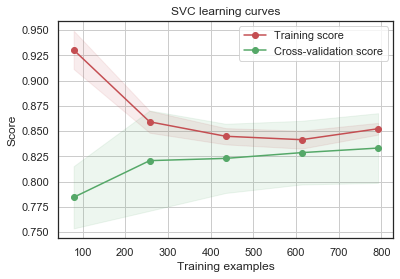

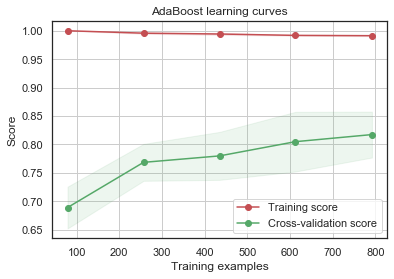

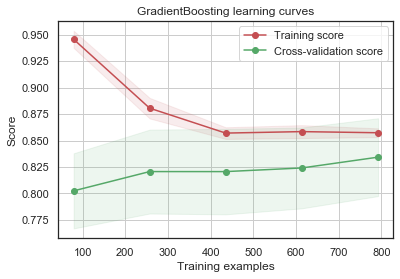

In [212]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

- GradientBoosting 및 Adaboost 분류기는 데이터셋에 과적합하는 경향이 있다.
- 교차 검증 곡선에 따라 GradientBoosting과 Adaboost는 더 많은 훈련 예제가 들어가면 성능이 더 좋았다.
- SVC와 ExtraTree 분류기는 훈련 곡선과 교차 검증 곡선이 밀접하기 때문에 예측을 더 잘 일반화시키는 것으로 보인다.

#### 6.1.4 Feature importance of tree based classifiers

- 생존가능성을 예측하기에 가장 중요한 요인을 찾기 위해(Feature Importance) 4개의 트리 기반 분류기에 대한 기능 중요성을 표시해보았다.

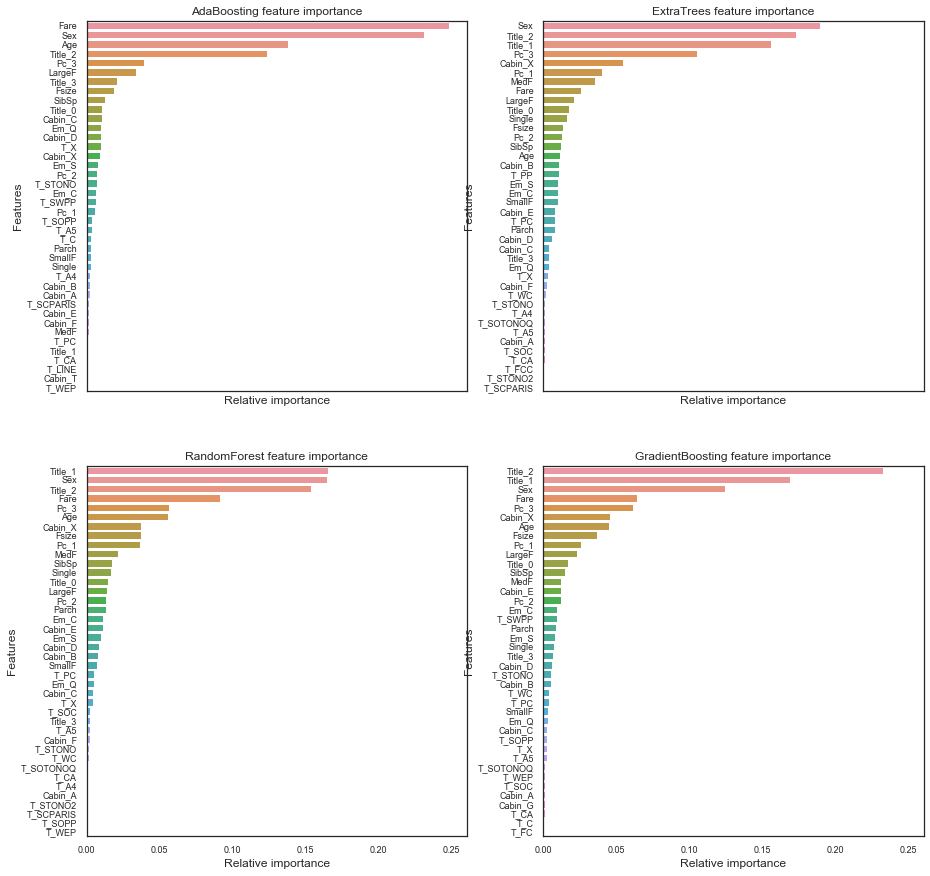

In [211]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

- 4개의 트리 기반 분류기(Adboost, ExtraTree, RandomForest 및 GradientBoosting)에 대한 기능 중요도를 표시합니다.

- 우리는 네 개의 분류기가 상대적 중요도에 따라 상위 특징을 가지고 있다는 것에 확인할 수 있다. 모두 다 똑같은 순서를 가지지 않지만 'Fare', 'Title_2', 'Age', 'Sex'와 같은 몇 가지 공통의 중요한 특징을 공유하고 있는 것을 볼 수 있다.

- Ms/Mlle/Mme/Miss/Ms 범주가 Sex와 높은 상관 관계를 가지고 있음을 나타내는 Title_2이다.

<요약>

- Pc_1, Pc_2, Pc_3, 요금은 승객의 일반적인 사회적 지위를 의미한다.

- 성별 및 제목_2(Mrs/Mlle/Mme/Ms)와 제목_3(Mr)은 성별을 나타냅니다.

- 나이 및 제목_1(주)은 승객의 나이를 나타냅니다.

- Fsize, LargeF, MedF, Single은 승객 패밀리의 크기를 나타냅니다.

이 4가지 분류기의 특징적 중요성에 따르면 생존 예측은 보트 안 위치보다 승객들의 연령, 성별, 가족 규모, 사회적 지위 등과 더 관련이 있는 것으로 보인다.

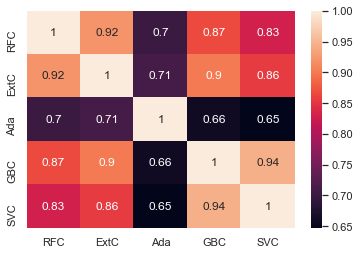

In [215]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")

ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)

g= sns.heatmap(ensemble_results.corr(),annot=True)

- AdaBoost를 다른 분류기와 비교할 때를 제외하고는 5개의 분류자에 대한 예측은 매우 유사한 것으로 보인다.

- 5개의 분류기는 거의 같은 예측을 제공하지만 약간의 차이가 있다. 5개의 분류자 예측 간의 이러한 차이는 조합 투표를 고려하기에 충분하다.

### 6.2 Ensemble modeling
#### 6.2.1 Combining models

- 제작자는 5개의 분류기에서 나오는 예측들을 조합하기 위해 Voting를 선택했다.그리고 voting 옵션은 soft를 사용했다.

In [216]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

### 6.3 Prediction
#### 6.3.1 Predict and Submit results

In [218]:
test_Survived = pd.Series(votingC.predict(test),name='Survived')

results= pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting2.csv",index=False)